## Import Libraries

In [1]:
import matplotlib.pyplot as plt
import nltk
nltk.download('punkt')
import pandas as pd
import requests
import json
from entity_options import get_entity_options
from ckg_functions import arxiv_search, read_url, joining, \
    clean_article, stop_remove, query_raw, parse_entity, make_df


[nltk_data] Downloading package punkt to
[nltk_data]     /Users/olawumiolasunkanmi/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


## Import Data

In [2]:
## SINGLE URL ARTICLE EXTRACT
url = 'https://www.scientificarchives.com/admin/assets/articles/pdf/beta-sitosterol-as-immunostimulant-antioxidant-and-inhibitor-of-sars-cov-2-spike-glycoprotein-20210329100327.pdf'

# url = 'https://www.frontiersin.org/articles/10.3389/fphar.2021.656103/pdf'
wikiurl = 'https://en.wikipedia.org/wiki/COVID-19'

article_txt = read_url(url) 
# title = "".join(article_txt.split("\n")[10:12])
# author = "".join(article_txt.split("\n")[13])
# affiliation = "".join(article_txt.split("\n")[15:16])
# print('Title:', title, '\nAuthor(s):', author, '\nAffiliation:', affiliation)

from spacy.lang.en.stop_words import STOP_WORDS
sentences_ = joining(nltk.tokenize.sent_tokenize(clean_article(article_txt)))
sentences = stop_remove(STOP_WORDS, sentences_)
sentences[3:6]

Total Pages: 4


/opt/homebrew/Caskroom/miniforge/base/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


['The Beta-sitosterol docked SARS-CoV-2 MF° study binding affinity (kcal/mol) comparison favipiravir.',
 'It found favipiravir binding affinity, 5.7 kcal/mol Beta-sitosterol 6.9 kcal/mol.',
 '5.7 kcal/mol Beta-sitosterol 6.9 kcal/mol.']

## Named Entity Recognition (NER)  IN BIOMEDICAL DOMAIN

The named entity linking technique detects relevant concepts in the text and tries to map them to the target knowledge base. In the biomedical domain, some of the target knowledge bases are: BERN API of BioBERT, NCBI, UMLS, Gene Ontology, MESH, ChEMBL, OMIM, ENSEMBL and others. 

#### 1. Spacy models via en_ner_bc5cdr_md, en_ner_bionlp13cg_md

In [3]:
from collections import Counter
from pathlib import Path


import spacy
from spacy import displacy
import en_ner_bc5cdr_md, en_ner_bionlp13cg_md
from spacy.matcher import Matcher 
from spacy.tokens import Span 
from tqdm import tqdm

# nlp = en_ner_bc5cdr_md.load()
nlp = en_ner_bionlp13cg_md.load()

/opt/homebrew/Caskroom/miniforge/base/lib/python3.9/site-packages/spacy/util.py:837: UserWarning: [W095] Model 'en_ner_bc5cdr_md' (0.5.0) was trained with spaCy v3.2 and may not be 100% compatible with the current version (3.3.0). If you see errors or degraded performance, download a newer compatible model or retrain your custom model with the current spaCy version. For more details and available updates, run: python -m spacy validate
  warnings.warn(warn_msg)
/opt/homebrew/Caskroom/miniforge/base/lib/python3.9/site-packages/spacy/util.py:837: UserWarning: [W095] Model 'en_ner_bionlp13cg_md' (0.5.0) was trained with spaCy v3.2 and may not be 100% compatible with the current version (3.3.0). If you see errors or degraded performance, download a newer compatible model or retrain your custom model with the current spaCy version. For more details and available updates, run: python -m spacy validate
  warnings.warn(warn_msg)


In [4]:
docs = nlp(''.join(sentences[:-1]))
print('Entities in the article:', len(docs.ents))
labels = [x.label_ for x in docs.ents]
print('Distinct Entity counts:', Counter(labels))
nerEnts = displacy.render(docs, style="ent", options=get_entity_options(random_colors=True))
output_path = Path("./images/sentence.svg")
# output_path.open("w", encoding="utf-8").write(nerEnts)

Entities in the article: 85
Distinct Entity counts: Counter({'SIMPLE_CHEMICAL': 25, 'GENE_OR_GENE_PRODUCT': 23, 'CELL': 12, 'ORGAN': 5, 'AMINO_ACID': 5, 'TISSUE': 4, 'CELLULAR_COMPONENT': 3, 'ORGANISM': 3, 'PATHOLOGICAL_FORMATION': 2, 'ORGANISM_SUBSTANCE': 2, 'CANCER': 1})


In [5]:
# options = {"compact": True, "bg": "#09a3d5",
#     "color": "white", "font": "Source Sans Pro"}
displacy.render(docs.sents, style='dep')
#     name = 'sentence' + str(i) + '.svg'
    #     output_path = Path("./images/" + name)
    # # output_path.open("w", encoding="utf-8").write(svg)

Some of the Named Entity Recognition (NER) Model identified entities with high ambiguity while some good ones are limited in term of the number of entities identified. [details](https://allenai.github.io/scispacy/)



|model		   | Entity Types|
| -- |-- |
|en_ner_craft_md|  GGP, SO, TAXON, CHEBI, GO, CL|
|en_ner_jnlpba_md|  DNA, CELL_TYPE, CELL_LINE, RNA, PROTEIN|
|en_ner_bc5cdr_md|	DISEASE, CHEMICAL|
|en_ner_bionlp13cg_md|	AMINO_ACID, ANATOMICAL_SYSTEM, CANCER, CELL, CELLULAR_COMPONENT, DEVELOPING_ANATOMICAL_STRUCTURE, GENE_OR_GENE_PRODUCT, IMMATERIAL_ANATOMICAL_ENTITY, MULTI-TISSUE_STRUCTURE, ORGAN, ORGANISM, ORGANISM_SUBDIVISION, ORGANISM_SUBSTANCE, PATHOLOGICAL_FORMATION, SIMPLE_CHEMICAL, TISSUE|



#### 2. BioBERT via BERN2 API

In [6]:
def get_entity(sentences):
    entity_list = []
    for s in tqdm(sentences):
        if s != ' ' or len(s)>1:
            entity_list.append(query_raw(s))
    return entity_list
entity_list = get_entity(sentences)
pd.json_normalize(entity_list)

100%|███████████████████████████████████████████| 62/62 [00:53<00:00,  1.16it/s]


,annotations,text,timestamp
0,"[{'id': ['mesh:C025473'], 'is_neural_normalize...",This article extension recently published arti...,Tue May 17 22:43:21 +0000 2022
1,"[{'id': ['NCBIGene:100129339'], 'is_neural_nor...","Bark Extract, Structural Elucidation, Molecula...",Tue May 17 22:43:22 +0000 2022
2,"[{'id': ['mesh:C025473'], 'is_neural_normalize...",The article describes detailed procedure isola...,Tue May 17 22:43:23 +0000 2022
3,"[{'id': ['mesh:C025473'], 'is_neural_normalize...",The Beta-sitosterol docked SARS-CoV-2 MF study...,Tue May 17 22:43:24 +0000 2022
4,"[{'id': ['mesh:C462182'], 'is_neural_normalize...","It found favipiravir binding affinity, 5.7 kca...",Tue May 17 22:43:25 +0000 2022
...,...,...,...
57,"[{'id': ['mesh:C025473'], 'is_neural_normalize...","Literature supports immunostimulant, antiviral...",Tue May 17 22:44:11 +0000 2022
58,"[{'id': ['CHEBI:46882'], 'is_neural_normalized...",Interactions te dr Via Ti erverscraterropen Bo...,Tue May 17 22:44:11 +0000 2022
59,"[{'id': ['mesh:D006859'], 'is_neural_normalize...","It formed hydrogen bond Ala-B:419, good better...",Tue May 17 22:44:12 +0000 2022
60,"[{'id': ['mesh:C025473'], 'is_neural_normalize...","From present commentary, concluded Beta-sitost...",Tue May 17 22:44:13 +0000 2022


### Disambiguate the Named Entities further

In [7]:
parsed_entities = parse_entity(entity_list)


## Get a structured tabular data for other downstream task

In [8]:
dataset = make_df(parsed_entities)
dataset['entity_id'] = [''.join(i) for i in dataset['entity_id']]
dataset

,entity_id,entity_type,entity,entity_proba,text,timestamp,text_sha256
0,mesh:C025473,drug,Beta-sitosterol,0.999001,This article extension recently published arti...,Tue May 17 22:43:21 +0000 2022,928eea1e4d68774308cb56aa604fe82bae768a6edfa07f...
1,NCBITaxon:45164,species,Muntingia Calabura,0.614166,This article extension recently published arti...,Tue May 17 22:43:21 +0000 2022,928eea1e4d68774308cb56aa604fe82bae768a6edfa07f...
2,NCBIGene:100129339,gene,SARS-CoV-2 Spike Glycoprotein,0.995957,"Bark Extract, Structural Elucidation, Molecula...",Tue May 17 22:43:22 +0000 2022,5075ce5bc8acd35f25cf67c50abeb1e5ba00a6a9f4f52b...
3,CUI-less*,disease,SARS,1.000000,"Bark Extract, Structural Elucidation, Molecula...",Tue May 17 22:43:22 +0000 2022,5075ce5bc8acd35f25cf67c50abeb1e5ba00a6a9f4f52b...
4,mesh:C025473,drug,Beta-sitosterol,0.998682,The article describes detailed procedure isola...,Tue May 17 22:43:23 +0000 2022,e08bfa3fe76546325c733dc96657d792fcba89d198780b...
...,...,...,...,...,...,...,...
170,NCBIGene:59272,gene,ACE-2,0.994556,"From present commentary, concluded Beta-sitost...",Tue May 17 22:44:13 +0000 2022,7057bbbf872af2149270de850a075a1b4c2dc88cc726f0...
171,NCBIGene:59272,gene,ACE-2,0.994756,"From present commentary, concluded Beta-sitost...",Tue May 17 22:44:13 +0000 2022,7057bbbf872af2149270de850a075a1b4c2dc88cc726f0...
172,mesh:C025473,drug,Beta-sitosterol,0.999667,If increase dietary intake Beta-sitosterol phy...,Tue May 17 22:44:13 +0000 2022,d6c89201a8eeb6607471f32cdf9f1a7f865a42cc17e863...
173,mesh:D010840,drug,phytosterols,0.998893,If increase dietary intake Beta-sitosterol phy...,Tue May 17 22:44:13 +0000 2022,d6c89201a8eeb6607471f32cdf9f1a7f865a42cc17e863...


In [9]:
gene_dt = dataset[dataset['entity_type']=='gene']
species_dt = dataset[dataset['entity_type']=='species']
drug_dt= dataset[dataset['entity_type']=='drug']
disease_dt = dataset[dataset['entity_type']=='disease']
DNA_dt = dataset['entity'][dataset['entity_type']=='DNA']
cell_type_dt = dataset[dataset['entity_type']=='cell_type']
cell_line_dt = dataset[dataset['entity_type']=='cell_line']
RNA_dt = dataset[dataset['entity_type']=='RNA']

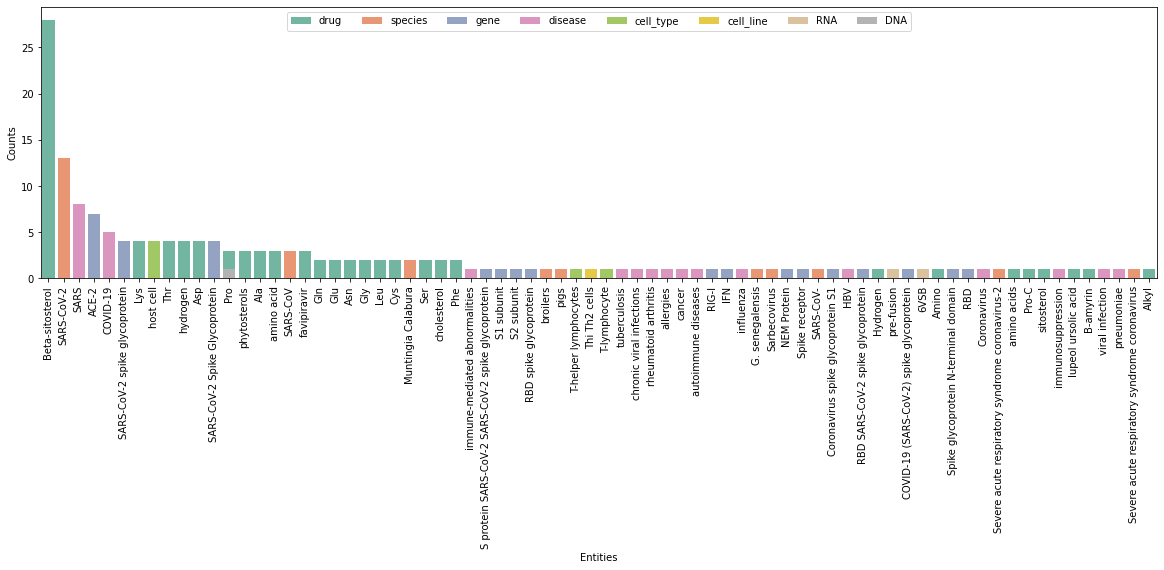

In [10]:
import seaborn as sns
plt.figure(figsize=(20, 5))
ax = sns.countplot(x="entity", hue="entity_type", dodge=False,
                    order=dataset['entity'].value_counts().sort_values(ascending=False).index, 
                    data=dataset, palette="Set2")
plt.xticks(rotation=90)
plt.legend(loc='upper center', ncol=len(dataset.entity_type.unique()))   
plt.xlabel('Entities')
plt.ylabel('Counts')
plt.savefig('Entities Freq Counts Colored by Type.png')
None

In [148]:
from neo4j import GraphDatabase, basic_auth

host = 'bolt://3.215.142.6:7687'
user = 'neo4j'
password = 'humps-mediums-apples'


driver = GraphDatabase.driver(host,auth=(user, password))

def cypher_query(query, params=None): 
    with driver.session(database="neo4j") as session:
        results = session.run(query, params)
        return pd.DataFrame([r.values() for r in results], columns=results.keys())
    driver.close()


In [149]:
## Create Entities, and Sentences nodes
## Connect Sentences to Entity Mentions 
cypher_query("""
        UNWIND $data as row
        MERGE (s:Sentence{id:(row.text_sha256)})
        SET s.text = row.text
        WITH s, row.entities as entities
        UNWIND entities as entity
        MERGE (e:Entity{id:entity.entity_id})
        ON CREATE SET  e.name = entity.entity,
                        e.type = entity.entity_type,
                        e.proba = entity.entity_proba
                      
        MERGE (s)-[m:MENTIONS]->(e)
        ON CREATE SET m.count = 1
        ON MATCH SET m.count = m.count + 1
        """, 
            {'data': parsed_entities})

""


In [150]:
## Color each entity node by the entity type
cypher_query("""
        MATCH (n:Entity)
        WITH DISTINCT n.type AS type, collect(DISTINCT n) AS entity
        CALL apoc.create.addLabels(entity, [apoc.text.upperCamelCase(type)]) YIELD node
        RETURN *
        """)

,entity,node,type
0,"[(proba, name, embedding, id, type), (proba, n...","(proba, name, embedding, id, type)",drug
1,"[(proba, name, embedding, id, type), (proba, n...","(proba, name, embedding, id, type)",drug
2,"[(proba, name, embedding, id, type), (proba, n...","(proba, name, embedding, id, type)",drug
3,"[(proba, name, embedding, id, type), (proba, n...","(proba, name, embedding, id, type)",drug
4,"[(proba, name, embedding, id, type), (proba, n...","(proba, name, embedding, id, type)",drug
5,"[(proba, name, embedding, id, type), (proba, n...","(proba, name, embedding, id, type)",drug
6,"[(proba, name, embedding, id, type), (proba, n...","(proba, name, embedding, id, type)",drug
7,"[(proba, name, embedding, id, type), (proba, n...","(proba, name, embedding, id, type)",drug
8,"[(proba, name, embedding, id, type), (proba, n...","(proba, name, id, embedding, type)",drug
9,"[(proba, name, embedding, id, type), (proba, n...","(proba, name, embedding, id, type)",drug


### Most mentioned ENTITY

In [151]:
cypher_query("""
    MATCH (e:Entity)
    RETURN e.name AS entity,
            e.type as object_type,
           size((e)<-[:MENTIONS]-()) AS mentions
    ORDER BY mentions
    DESC LIMIT 10
    """)

,entity,object_type,mentions
0,Beta-sitosterol,drug,27
1,Muntingia Calabura,species,18
2,SARS-CoV-2 Spike Glycoprotein,gene,8
3,SARS,disease,5
4,COVID-19,disease,5
5,hydrogen,drug,4
6,ACE-2,gene,4
7,favipiravir,drug,3
8,SARS,disease,3
9,phytosterols,drug,3


### ENTITY Mention across sentences for a singular entity

In [152]:
# Find sentences that mention a specific medical entity.

cypher_query("""
            MATCH (e:Entity)<-[:MENTIONS]-(s:Sentence)
            WHERE e.name = "ACE-2"
            RETURN s.text as sentence,
            e.name as entity_searched,
            e.type as object_type
            """)

,sentence,entity_searched,object_type
0,This S protein SARS-CoV-2 SARS-CoV-2 spike gly...,ACE-2,gene
1,"From present commentary, concluded Beta-sitost...",ACE-2,gene
2,The S1 subunit contains receptor binding domai...,ACE-2,gene
3,SARS-CoV-2 spike glycoprotein causes invasion ...,ACE-2,gene


### ENTITY CoCCURENCE

In [153]:
cypher_query("""
            MATCH (e1:Entity)<-[:MENTIONS]-()-[:MENTIONS]->(e2:Entity)
            WHERE id(e1) < id(e2)
            RETURN e1.name as entity1, e2.name as entity2, count(*) as cooccurrence
            ORDER BY cooccurrence DESC
            """)

,entity1,entity2,cooccurrence
0,Beta-sitosterol,Muntingia Calabura,10
1,Muntingia Calabura,SARS-CoV-2 Spike Glycoprotein,7
2,Beta-sitosterol,SARS,5
3,Beta-sitosterol,SARS-CoV-2 Spike Glycoprotein,4
4,Beta-sitosterol,favipiravir,3
...,...,...,...
255,hydrogen,Asp,1
256,SARS-CoV-2 Spike Glycoprotein,Asp,1
257,Muntingia Calabura,Asp,1
258,Beta-sitosterol,Asp,1


## RELATIONSHIP EXTRACTION

#### APRIORI RULES

Example:

print(dataset['text'][1])

doc = nlp(dataset['text'][1])# print token, dependency, POS tag 

for tok in doc: 
 
 print(tok.text, "-->",tok.dep_,"-->", tok.pos_)

get_relation(doc)

In [154]:
def get_relation(sent):

    doc = nlp(sent)

    # Matcher class object 
    matcher = Matcher(nlp.vocab)

    #define the rule 
    rule = [{'DEP':'ROOT'}, 
            {'DEP':'prep','OP':"?"},
            {'DEP':'agent','OP':"?"},  
            {'POS':'VRB','OP':"?"}] 

    matcher.add("matching", [rule], on_match=None) 
    matches = matcher(doc)
    for match_id, start, end in matches:
        span = doc[start:end]  # The matched span
    return(span.text)

relations = [get_relation(i) for i in tqdm(sentences)]
relations[:5]

# # Not too great because size_y], of-sitosterol, kcal/mol were added as part of verbs

100%|██████████████████████████████████████████| 62/62 [00:00<00:00, 158.33it/s]


['extension', 'Extract', 'describes', 'docked', 'found']

In [155]:
bd = [ 'Extract', 'describes', 'entry', 'concluded', 'Li', 'reported', 'investigated', \
      'Bouic', 'Zhou', 'Parvez', 'Fraile', 'docked', 'declared', 'found', 'kcal/mol', \
      'investigated', 'reveals', 'emphasized', 'coronavirus-2',\
     'of-sitosterol', 'showed', 'noted', 'preparation', 'spike', 'shows', \
      'identified', 'size_y']
rels = [x.upper() for x in relations if x not in bd]
rels[:5]

['EXTENSION', 'FORMED', 'CAUSED', 'AFFECTED', 'ENCODED']

### Zero-shot Relationship Extractor

In [172]:
from ckg_functions import predict_relations
predicted_rels = predict_relations(parsed_entities, rels)

100%|███████████████████████████████████████████| 52/52 [10:19<00:00, 11.92s/it]


In [173]:
#Creating relationship between pair of entities
cypher_query("""
        UNWIND $data as row
        MATCH (source:Entity {id: row.head, name: row.head_name, type: row.head_type}), 
              (target:Entity {id: row.tail, name: row.tail_name, type: row.tail_type})
        MATCH (text:Sentence {id: row.source})
        MERGE (source)-[r:REL {name: row.con, source: row.source}]->(target)
        // MERGE (text)-[:MENTIONS]->(r)
        """, {'data': predicted_rels})

""


In [174]:
# Examine the extracted relationships between entities
cypher_query("""
            MATCH (s:Entity)-[r:REL]->(t:Entity)
            RETURN s.name as source_entity, 
            r.name as relation, 
            t.name as target_entity
            """) 

,source_entity,relation,target_entity
0,hydrogen,FORMED,Beta-sitosterol
1,B-amyrin,SUPPORTS,Beta-sitosterol
2,favipiravir,FORMED,Beta-sitosterol
3,RBD spike glycoprotein,TARGETED,Beta-sitosterol
4,Alkyl,SUPPORTS,Beta-sitosterol
...,...,...,...
87,Spike receptor,CONTAINS,Coronavirus spike glycoprotein S1
88,RBD,CONTAINS,Coronavirus spike glycoprotein S1
89,Spike receptor,CONTAINS,Coronavirus spike glycoprotein S1
90,Amino,FACILITATES,Alkyl


## Graph Operations

In [178]:
#CHANGE THE EDGE TO UNDIRECTED SO THAT BOTH ENDS WILL BE TRAVERSED

cypher_query("""CALL gds.graph.project(
          'entity_undir',
          'Entity',
          {REL: {orientation: 'UNDIRECTED'}}
        )""")

## Page rank algorithm for each node

In [195]:
cypher_query("""CALL gds.pageRank.stream('entity_undir', {scaler: "L1Norm"})
    YIELD nodeId, score
    RETURN gds.util.asNode(nodeId).name AS name, score
    // collect(DISTINCT gds.util.asNode(nodeId).name) AS name, score
    ORDER BY score DESC
    """)

,name,score
0,Beta-sitosterol,0.183523
1,favipiravir,0.036133
2,hydrogen,0.036133
3,immune-mediated abnormalities,0.029553
4,tuberculosis,0.029553
5,rheumatoid arthritis,0.029553
6,allergies,0.029553
7,cancer,0.029553
8,autoimmune diseases,0.029553
9,RBD,0.029553


In [196]:
cypher_query("""CALL gds.pageRank.write('entity_undir', {
  maxIterations: 20,
  dampingFactor: 0.05,
  scaler: "L1Norm",
  writeProperty: 'pagerank'
})
YIELD nodePropertiesWritten, ranIterations
    """)

,nodePropertiesWritten,ranIterations
0,60,6


### NODE EMBEDDING, SIMILARITY SCORE AND 2D PROJECTION

In [197]:
## USE fastRP model go get the low-level vector Representation of the nodes
## Enbedding size : 128
cypher_query("""
        CALL gds.fastRP.stream('entity_undir',
          {
            embeddingDimension: 128
          }
        )
        YIELD nodeId, embedding
        RETURN gds.util.asNode(nodeId).name AS entity, embedding
        
        LIMIT 20
        """)

,entity,embedding
0,Beta-sitosterol,"[-0.08923456072807312, 0.2838536500930786, 0.0..."
1,Muntingia Calabura,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2,SARS-CoV-2 Spike Glycoprotein,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
3,SARS,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4,Muntingia Calabura,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
5,favipiravir,"[-0.18787920475006104, 0.3479551374912262, 0.0..."
6,hydrogen,"[-0.1886489987373352, 0.31881821155548096, 0.0..."
7,SARS-CoV-2 Spike Glycoprotein,"[-0.08986242115497589, 0.24617716670036316, 0...."
8,viral infection,"[-0.08986242115497589, 0.24617716670036316, 0...."
9,pneumoniae,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


The embedding get sparsed for some nodes . Add the embedding as property for each corresponding nodes

In [198]:
cypher_query("""CALL gds.fastRP.write(
      'entity_undir',
      {
        embeddingDimension: 128,
        writeProperty: 'embedding'
      }
    )""")

,nodeCount,nodePropertiesWritten,preProcessingMillis,computeMillis,writeMillis,configuration
0,60,60,0,5,27,"{'writeConcurrency': 4, 'nodeSelfInfluence': 0..."


In [199]:
cypher_query("""CALL gds.nodeSimilarity.stream('entity_undir', {topK: 4})
        YIELD node1, node2, similarity
        RETURN gds.util.asNode(node1).name AS Entity1, 
                gds.util.asNode(node1).type AS Entity1_type,
                gds.util.asNode(node2).name AS Entity2, 
                gds.util.asNode(node2).type AS Entity2_type,
                similarity
        ORDER BY similarity DESCENDING, Entity1, Entity2 """)

 

,Entity1,Entity1_type,Entity2,Entity2_type,similarity
0,COVID-19,disease,RBD spike glycoprotein,gene,1.000000
1,COVID-19,disease,SARS-CoV-2 Spike Glycoprotein,gene,1.000000
2,COVID-19,disease,cholesterol,drug,1.000000
3,COVID-19,disease,viral infection,disease,1.000000
4,RBD spike glycoprotein,gene,COVID-19,disease,1.000000
...,...,...,...,...,...
99,Beta-sitosterol,drug,RIG-I,gene,0.111111
100,Beta-sitosterol,drug,influenza,disease,0.111111
101,Beta-sitosterol,drug,immunosuppression,disease,0.058824
102,S1 subunit,gene,Beta-sitosterol,drug,0.058824


## Node and Edges Enrichment

In [103]:
drug_dt.entity.unique()

array(['Beta-sitosterol', 'favipiravir', 'hydrogen', 'cholesterol',
       'phytosterols', 'B-amyrin', 'lupeol ursolic acid', 'sitosterol',
       'amino acid', 'Ala', 'Pro-C', 'Lys', 'Thr', 'Ser', 'Asp', 'Phe',
       'Cys', 'Glu', 'Gln', 'Gly', 'Pro', 'Leu', 'Asn', 'amino acids',
       'Amino', 'Hydrogen', 'Alkyl'], dtype=object)

In [129]:
# mesh enrichment
#['cholesterol', lupeol ursolic acid, Ala, Lys, Ser, ]
cypher_query("""
    MATCH (e:Entity)
    WHERE e.name = 'Gly'
    WITH e.name as names
    CALL apoc.load.json("http://string-db.org/api/json/network?identifier="+names+"&species=9606") YIELD value
    RETURN names as Original_name,
            collect(DISTINCT value.preferredName_A) AS Name1,
            // value.preferredName_A as Name1,
            value.preferredName_B as Name2,
            value.score as score
            ORDER BY score DESC
            LIMIT 5
    """)



,Original_name,Name1,Name2,score
0,Gly,[CNDP1],CARNS1,0.976
1,Gly,[CNDP2],CARNS1,0.971
2,Gly,[CNDP2],CNDP1,0.965
3,Gly,[C9orf41],CARNS1,0.963
4,Gly,[CNDP1],C9orf41,0.944


In [ ]:
https://documentation.uts.nlm.nih.gov/rest/definitions/

### Entity mapping for further entity disambiguity and enrichment

There are several databases to acheive this, they include GeneOntology(GO), DiseaseOntology, StringDb, etc.


https://www.ncbi.nlm.nih.gov/books/NBK25498/#chapter3.ESearch__ESummaryEFetch
https://www.genecards.org/cgi-bin/carddisp.pl?gene=ETHE1&keywords=ETHE1#aliases_descriptions
https://omim.org/entry/608451


In [56]:
entity = '%0d'.join(dataset['entity'])
url = 'https://string-db.org/api/tsv/network?identifiers=' + entity + '&species=9606'
# url = 'https://webservice.thebiogrid.org/interactions/?'+ entity + '&accessKey=50ba231e9df6c1ae07687f0769b07402'

r = requests.get(url)

lines = r.text.split('\n') 
data = [l.split('\t') for l in lines]
print('original header', lines[0:2])
df = pd.DataFrame(data[1:-1], columns = data[0]) 
interactions = df[['preferredName_A', 'preferredName_B','score']]  
interactions = interactions.iloc[::2, :].reset_index(drop=True)
interactions['score'] = interactions['score'].astype(float)
interactions

original header ['stringId_A\tstringId_B\tpreferredName_A\tpreferredName_B\tncbiTaxonId\tscore\tnscore\tfscore\tpscore\tascore\tescore\tdscore\ttscore', '9606.ENSP00000219235\t9606.ENSP00000276927\tCCL22\tIFNA1\t9606\t0.465\t0\t0\t0\t0\t0\t0\t0.465']


,preferredName_A,preferredName_B,score
0,CCL22,IFNA1,0.465
1,CCL22,CCL2,0.977
2,CCL2,IL23A,0.414
3,CCL2,DDX58,0.524
4,CCL2,C3,0.529
5,CCL2,IFNA1,0.710
6,SARS,PSMD2,0.518
7,SARS,FARS2,0.756
8,SARS,EARS2,0.801
9,SARS,TARS2,0.853


In [ ]:
apikey = 2022b601-cd44-4631-b15d-051fd27daf40
version = args.version
string = args.string
uri = "https://uts-ws.nlm.nih.gov"
content_endpoint = "/rest/search/"+version

In [ ]:
## Entity Pair interaction Map
import networkx as nx
from matplotlib import cm
import nxviz as nz

G = nx.from_pandas_edgelist(df = interactions.loc[interactions['score']>0.80], \
                            source='preferredName_A', target='preferredName_B', edge_attr=["score"],\
                            create_using=nx.Graph)

nx.draw(G, pos=nx.spring_layout(G), with_labels = True)
plt.show()

In [ ]:


string_api_url = "https://version-11-5.string-db.org/api"
output_format = "tsv"
method = "enrichment"


request_url = "/".join([string_api_url, output_format, method])

params = {
    "identifiers" : "%0d".join(dataset['entity']), # your protein
    "species" : 9606} # species NCBI identifier 'humanspecies=9606

## Call STRING
response = requests.post(request_url, data=params)


## Read and parse the results
lines = response.text.split('\n')
data = [l.split('\t') for l in lines] # split each line into its components based on tabs
data
# convert to dataframe using the first row as the column names; drop empty, final row
df = pd.DataFrame(data[1:-1], columns = data[0]) 
# print(len(df))
enrichment = df[df['fdr'].astype(float) < 0.01][['category', 'inputGenes', 'preferredNames', 'p_value',	'fdr','description']].reset_index(drop=True)
enrichment